# Ensembles: Random Forest and GBDT

# Loading data

In [4]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# [1] Text Preprocessing
## [1.1] Data Cleaning: Deduplication

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [8]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [9]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [10]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

## [1.2] Stemming, stop-word removal and Lemmatization.

In [13]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [14]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'aren', 'but', 'll', 'of', 'after', "mightn't", 'haven', 'ain', 'she', 'any', 'an', 'didn', "you'll", 'same', 'don', 'them', 'up', 'should', 's', "needn't", 'about', 'herself', 'off', 'at', 'so', 'more', 'were', 'how', 'each', "weren't", 'a', "isn't", 'him', 'down', 'his', 'was', 'before', 'between', 'we', 'their', 'why', 'isn', 'theirs', 'ours', "it's", "haven't", 'again', 'other', 'both', 'some', 'and', 'yours', 'while', 'won', 'few', "wasn't", 'this', 'too', 'whom', 'been', 'then', 'does', 'do', 'o', "should've", "mustn't", 'hasn', 'for', 'under', "hadn't", "didn't", 'shouldn', "you've", 'can', 'ma', 'doing', 'in', 'further', 'hadn', 'weren', 'hers', 'only', 're', "shan't", "don't", 'over', 'by', 'are', 'have', 'shan', 'not', 'who', 'be', 'from', 'out', "couldn't", 'the', 'to', 'doesn', 'y', 'it', 'which', 'because', "hasn't", 'wasn', 'your', 'with', "aren't", "that'll", 'mustn', 'until', 'through', 'they', 'mightn', 'into', "doesn't", 'i', 'own', 't', 'did', 'against', 'here', 'th

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|██████████| 364171/364171 [09:08<00:00, 664.16it/s]


In [0]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

In [0]:
final.to_pickle("./amazon.pkl")

In [0]:
# read data from pickle file from previous stage
data = pd.read_pickle("./amazon.pkl")

# [2] Sorting data based on time

In [33]:
# Random sampling
df = final.take(np.random.permutation(len(final))[:40000])
df.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
297763,43030,46809,B0045AW4AA,A27QMQ9WK6YPSW,Karley,0,0,1,1326931200,Karley,The taste is fantastic. You can tell this sal...,tast fantast tell salsa made qualiti organ ing...
224238,252654,273910,B0026GBTQA,A1989WJVG7DHBK,OhioAtty,0,0,1,1341878400,"Love, love this with the Ayurvedic White Chai ...",Teavana had the Ayurvedic White Chai combined ...,teavana ayurved white chai combin store sampl ...


In [34]:
df['Time'] = pd.to_datetime(df['Time'])
# Sort by time
data = df.sort_values(by='Time')

print(data.shape)
print(data['Score'].value_counts())

(40000, 12)
1    33816
0     6184
Name: Score, dtype: int64


# [3] Spliting into train and test based on time (70:30)

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)


# [4] Bag of Words (BoW)

In [51]:
#Bag of words
count_vect = CountVectorizer(max_features=1000, min_df=10) 

X_train = count_vect.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)

X_test = count_vect.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (28000, 1000)
Test Data Size:  (12000, 1000)


## [4.1] Random Forest 

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 23.0min finished


Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best F1-Score: 91.20%
Best HyperParameter:  {'max_depth': 17, 'n_estimators': 200}


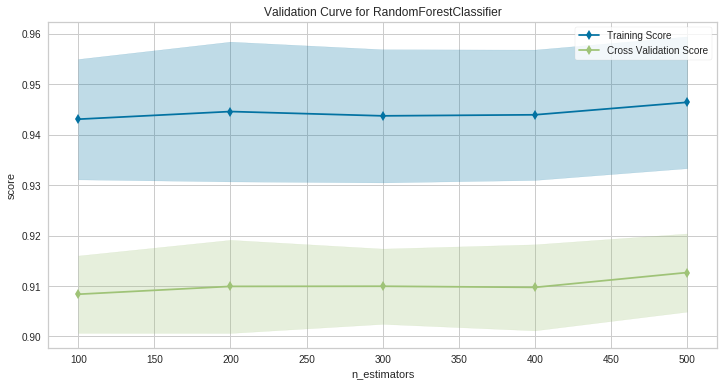

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [100,200,300,400,500]
depth = (range(1,20,4))
param_grid={"n_estimators":base_learners,"max_depth":depth}
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(max_features='sqrt', class_weight="balanced")
gsv = GridSearchCV(rf, param_grid,scoring='f1',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(X_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best Score: %.2f%%"%(gsv.best_score_*100))
print("Best HyperParameter: ",gsv.best_params_)
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(X_train, y_train)
viz.poof()

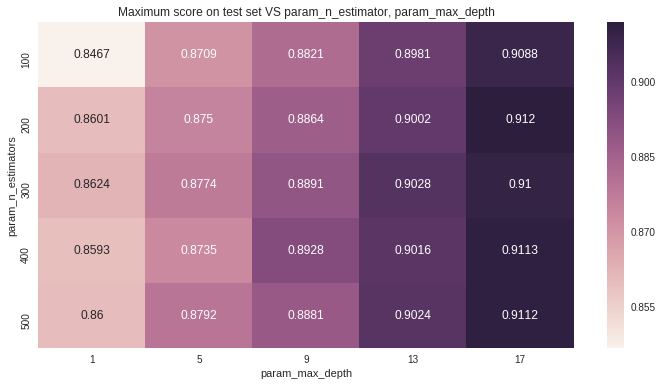

In [46]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

In [0]:
# This function plots the confusion, precision and recall matrices
def plot_confusion_matrix(x_test, y_pred):
    C = confusion_matrix(x_test, y_pred)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt="d", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

The optimal value of n_estimators is :  200
The optimal value of max_depth is :  17
Accuracy on test set: 83.313%
Precision on test set: 0.944
Recall on test set: 0.848
F1-Score on test set: 0.893


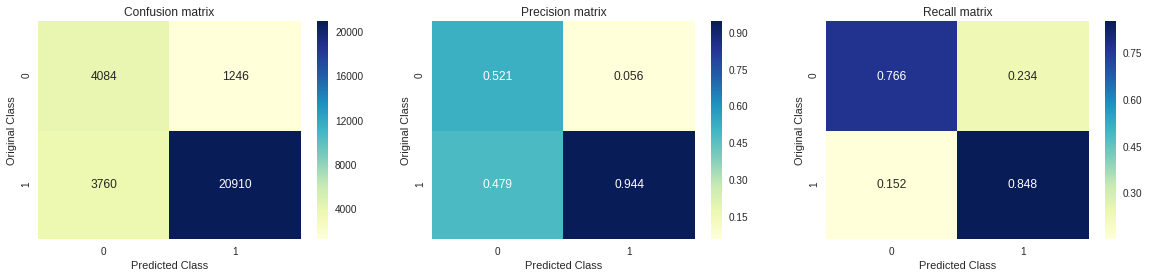

In [48]:
#Testing Accuracy on Test data
print("The optimal value of n_estimators is : ",optimal_n_estimators)
print("The optimal value of max_depth is : ",optimal_max_depth)
rf = RandomForestClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, max_features='sqrt', class_weight="balanced")
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [4.2] Feature Importance

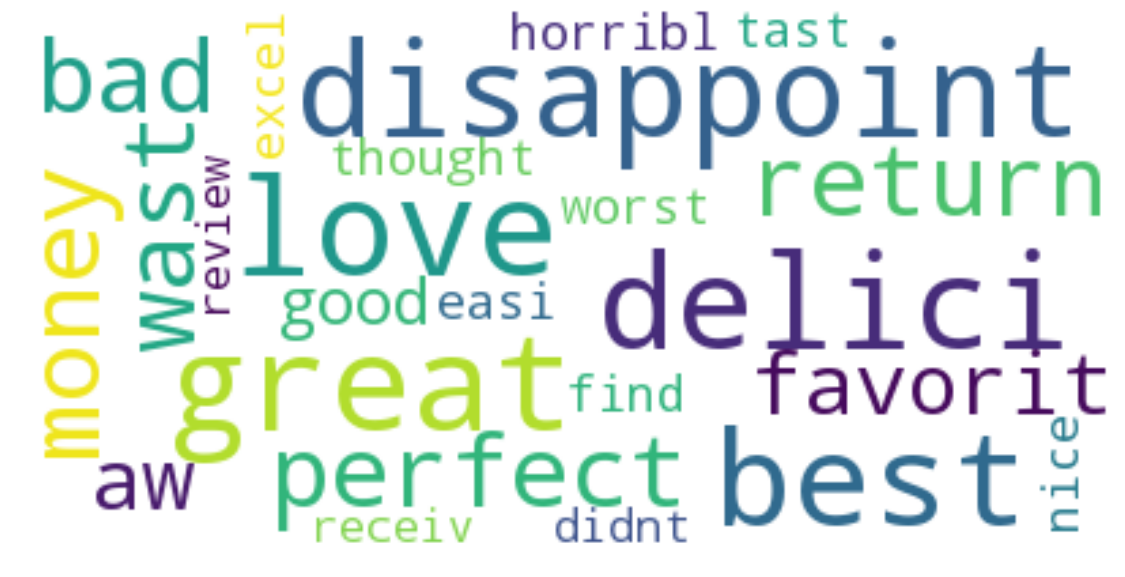

In [49]:
#https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

importances=rf.feature_importances_
feat_names=count_vect.get_feature_names()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]
a=np.take(feat_names,indices)
def words(X):
    comment_words=' '
    for words in X: 
        comment_words = comment_words + words + ' '
    return comment_words
a=words(a)

#Word Cloud
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")
wc.generate(a)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()




## [4.3] GBDT

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 77.8min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed: 106.1min finished


Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=700,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Best HyperParameter:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}
Best Accuracy: 93.75%


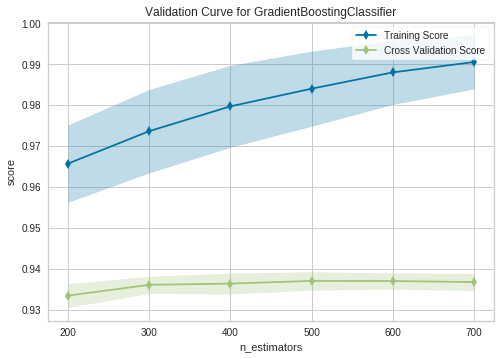

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [200,300,400,500,600,700]
Depths = [1,3,5,7,9,11,15]
Learning_rate = [0.05,0.1,0.2,0.3,0.5]

param_grid = {'n_estimators': base_learners, 'max_depth':Depths, 'learning_rate':Learning_rate}
tscv = TimeSeriesSplit(n_splits=5)
gb = GradientBoostingClassifier(max_features='sqrt')
gsv = GridSearchCV(gb, param_grid,scoring='f1',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(X_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth
optimal_learning_rate = gsv.best_estimator_.learning_rate

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(X_train, y_train)
viz.poof()

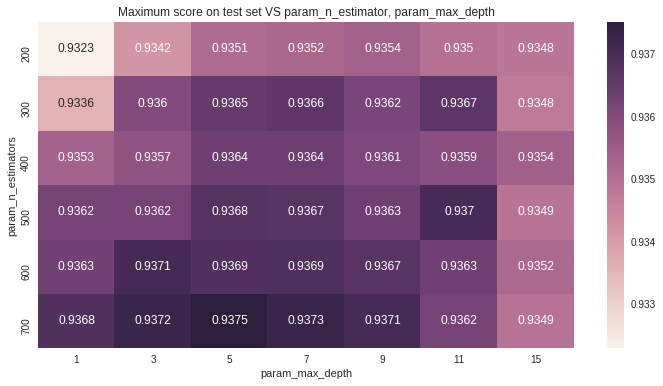

In [28]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

The optimal value of n_estimators is :  700
The optimal value of max_depth is :  5
The optimal value of learning_rate is :  0.1
Accuracy on test set: 88.658%
Precision on test set: 0.897
Recall on test set: 0.975
F1-Score on test set: 0.934


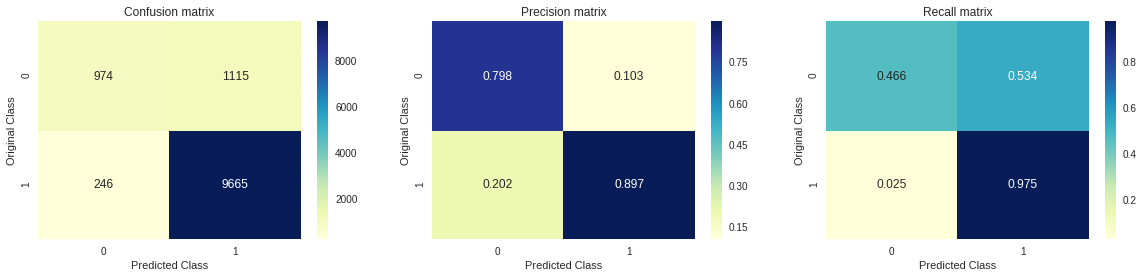

In [31]:
#Testing Accuracy on Test data
print("The optimal value of n_estimators is : ",optimal_n_estimators)
print("The optimal value of max_depth is : ",optimal_max_depth)
print("The optimal value of learning_rate is : ",optimal_learning_rate)

gb = GradientBoostingClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, learning_rate=optimal_learning_rate, max_features='sqrt')
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [4.4] Feature Importance

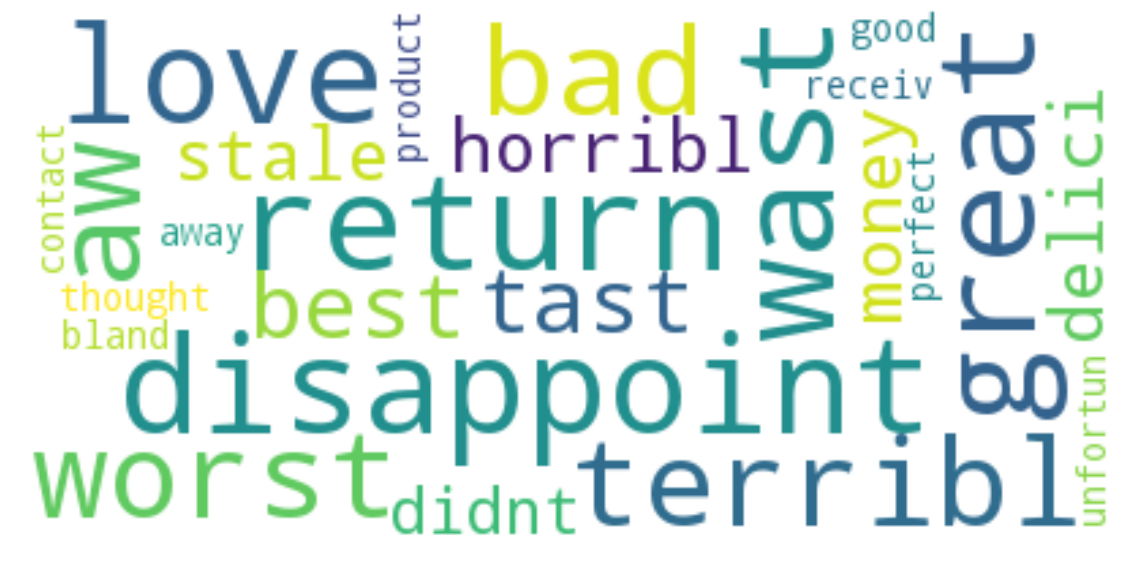

In [32]:
#https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

importances=gb.feature_importances_
feat_names=count_vect.get_feature_names()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]
a=np.take(feat_names,indices)
def words(X):
    comment_words=' '
    for words in X: 
        comment_words = comment_words + words + ' '
    return comment_words
a=words(a)

#Word Cloud
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")
wc.generate(a)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()




# [5] TF-IDF

In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(data['CleanedText'].values,data['Score'].values,test_size=0.3,shuffle=False)

In [36]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=500, min_df=10) #Using bi-grams
X_train = tfidf.fit_transform(X_train)
#Normalize Data
X_train = preprocessing.normalize(X_train)
print("Train Data Size: ",X_train.shape)
X_test = tfidf.transform(X_test)
#Normalize Data
X_test = preprocessing.normalize(X_test)
print("Test Data Size: ",X_test.shape)

Train Data Size:  (28000, 500)
Test Data Size:  (12000, 500)


## [5.1] Random Forest

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  8.7min finished


Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best F1-Score: 90.59%
Best HyperParameter:  {'max_depth': 17, 'n_estimators': 300}


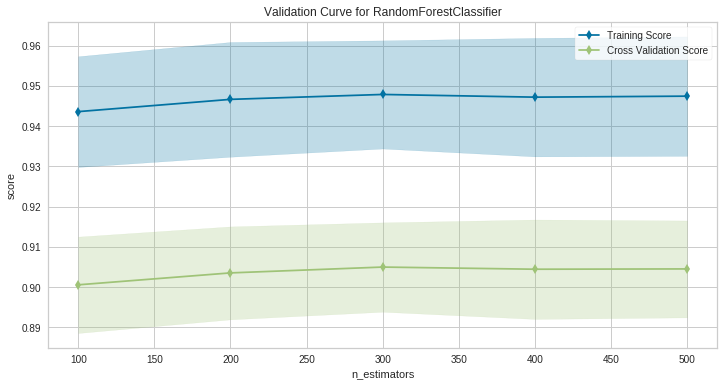

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [100,200,300,400,500]
depth = (range(1,20,4))
param_grid={"n_estimators":base_learners,"max_depth":depth}
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(max_features='sqrt', class_weight="balanced")
gsv = GridSearchCV(rf, param_grid,scoring='f1',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(X_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best Score: %.2f%%"%(gsv.best_score_*100))
print("Best HyperParameter: ",gsv.best_params_)
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(X_train, y_train)
viz.poof()

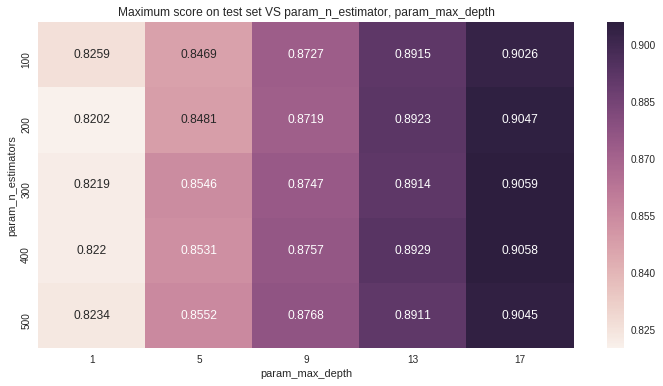

In [36]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

The optimal value of n_estimators is :  300
The optimal value of max_depth is :  17
Accuracy on test set: 82.150%
Precision on test set: 0.932
Recall on test set: 0.845
F1-Score on test set: 0.887


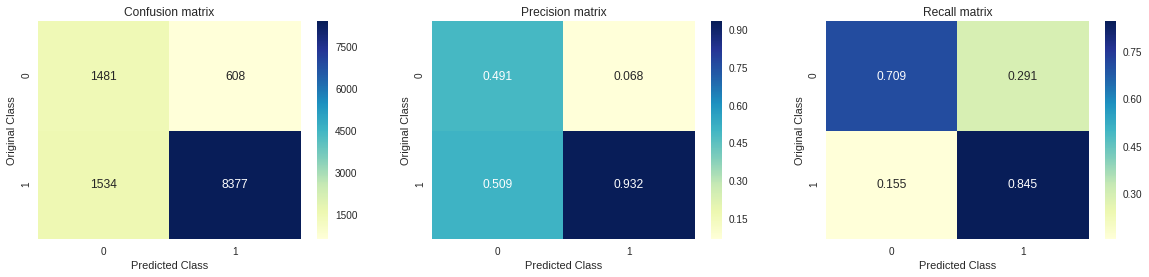

In [37]:
#Testing Accuracy on Test data
print("The optimal value of n_estimators is : ",optimal_n_estimators)
print("The optimal value of max_depth is : ",optimal_max_depth)
rf = RandomForestClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, max_features='sqrt', class_weight="balanced")
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [5.2] Feature Importance

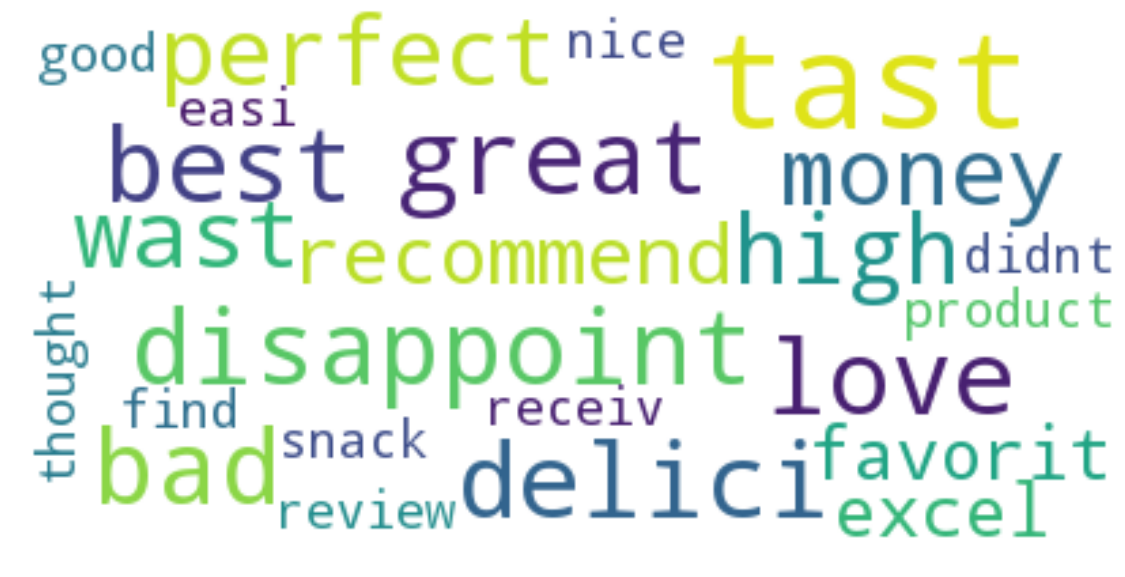

In [38]:
#https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

importances=rf.feature_importances_
feat_names=tfidf.get_feature_names()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]
a=np.take(feat_names,indices)
def words(X):
    comment_words=' '
    for words in X: 
        comment_words = comment_words + words + ' '
    return comment_words
a=words(a)

#Word Cloud
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")
wc.generate(a)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()




## [5.3] GBDT

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 22.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 54.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 93.6min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed: 125.8min finished


Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=7,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Best HyperParameter:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 600}
Best Accuracy: 93.11%


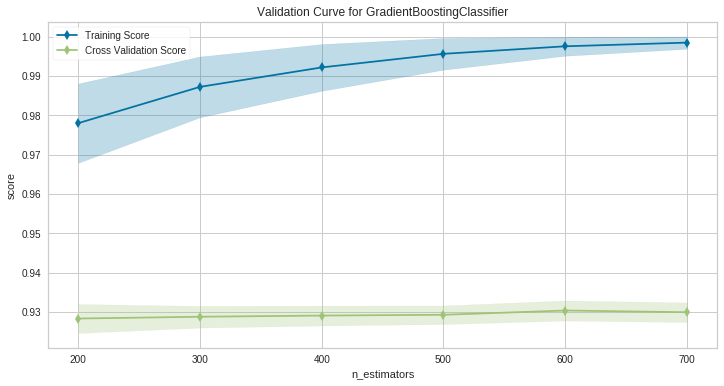

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [200,300,400,500,600,700]
Depths = [1,3,5,7,9,11,15]
Learning_rate = [0.05,0.1,0.2,0.3,0.5]

param_grid = {'n_estimators': base_learners, 'max_depth':Depths, 'learning_rate':Learning_rate}
tscv = TimeSeriesSplit(n_splits=5)
gb = GradientBoostingClassifier(max_features='sqrt')
gsv = GridSearchCV(gb, param_grid,scoring='f1',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(X_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth
optimal_learning_rate = gsv.best_estimator_.learning_rate

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(X_train, y_train)
viz.poof()

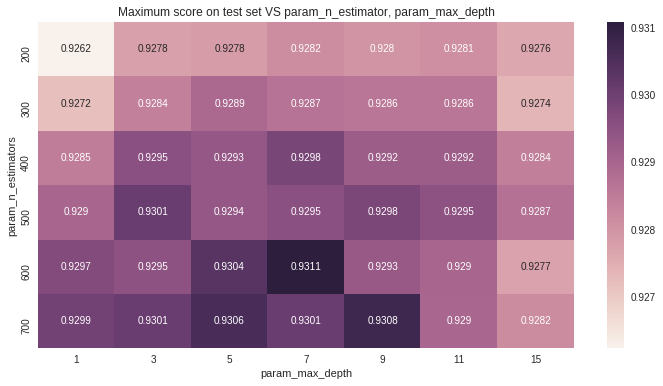

In [38]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

The optimal value of n_estimators is :  600
The optimal value of max_depth is :  7
The optimal value of learning_rate is :  0.1
Accuracy on test set: 88.242%
Precision on test set: 0.893
Recall on test set: 0.976
F1-Score on test set: 0.933


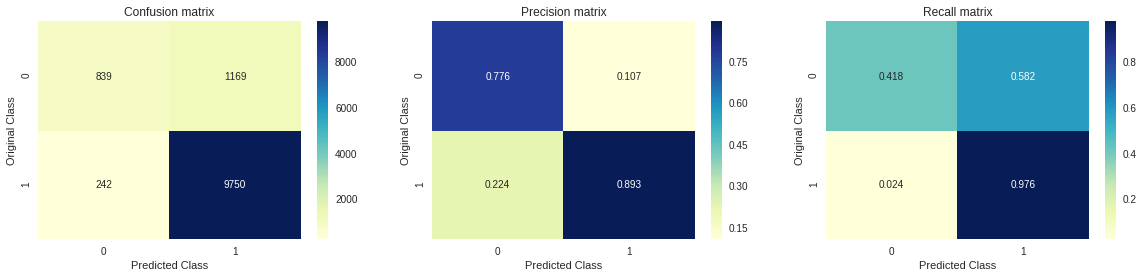

In [39]:
#Testing Accuracy on Test data
print("The optimal value of n_estimators is : ",optimal_n_estimators)
print("The optimal value of max_depth is : ",optimal_max_depth)
print("The optimal value of learning_rate is : ",optimal_learning_rate)

gb = GradientBoostingClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, learning_rate=optimal_learning_rate, max_features='sqrt')
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [5.4] Feature Importance

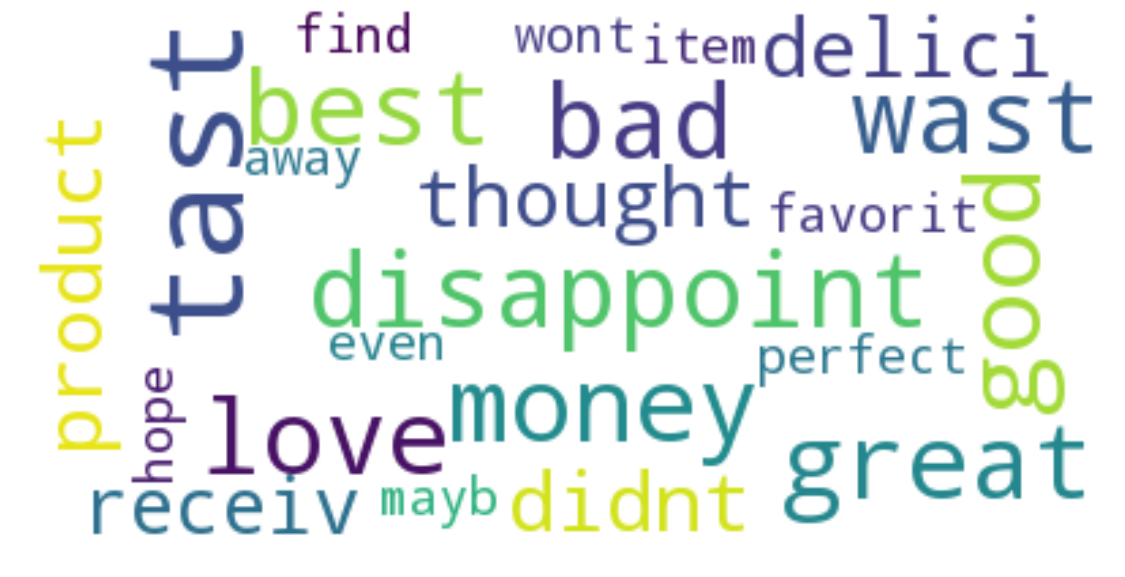

In [40]:
#https://www.datacamp.com/community/tutorials/wordcloud-python
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

importances=gb.feature_importances_
feat_names=tfidf.get_feature_names()

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1][:25]
a=np.take(feat_names,indices)
def words(X):
    comment_words=' '
    for words in X: 
        comment_words = comment_words + words + ' '
    return comment_words
a=words(a)

#Word Cloud
wc = WordCloud(max_font_size=50, max_words=100, background_color="white")
wc.generate(a)
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()




# [6] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent=[]
for sent in data['CleanedText'].values:
    list_of_sent.append(sent.split())

In [42]:
print(data['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

notori earli album camper van beethoven get present cds come cardboard singl sleev price except cheap there live album also includ lengthi booklet essay santa cruz colleg rocker lifestyl earli camper cvb fan sure thing godsend didnt snap earli print first album curious camper van beethoven set get
*****************************************************************
['notori', 'earli', 'album', 'camper', 'van', 'beethoven', 'get', 'present', 'cds', 'come', 'cardboard', 'singl', 'sleev', 'price', 'except', 'cheap', 'there', 'live', 'album', 'also', 'includ', 'lengthi', 'booklet', 'essay', 'santa', 'cruz', 'colleg', 'rocker', 'lifestyl', 'earli', 'camper', 'cvb', 'fan', 'sure', 'thing', 'godsend', 'didnt', 'snap', 'earli', 'print', 'first', 'album', 'curious', 'camper', 'van', 'beethoven', 'set', 'get']


In [0]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [44]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8456
sample words  ['notori', 'earli', 'camper', 'van', 'get', 'present', 'come', 'cardboard', 'singl', 'sleev', 'price', 'except', 'cheap', 'there', 'live', 'also', 'includ', 'lengthi', 'booklet', 'santa', 'cruz', 'colleg', 'lifestyl', 'fan', 'sure', 'thing', 'godsend', 'didnt', 'snap', 'print', 'first', 'curious', 'set', 'year', 'use', 'starbuck', 'decaf', 'regular', 'serv', 'espresso', 'pod', 'final', 'found', 'substitut', 'that', 'econom', 'much', 'better', 'tast', 'ive']


# [7] Avg Word2Vec

In [45]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 40000/40000 [00:48<00:00, 820.04it/s]

40000
50


In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(sent_vectors,data['Score'].values,test_size=0.3,shuffle=False)

## [7.1] Random Forest

### [7.1.1] Grid Search

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 27.8min finished


Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best Score: 92.64%
Best HyperParameter:  {'max_depth': 17, 'n_estimators': 300}


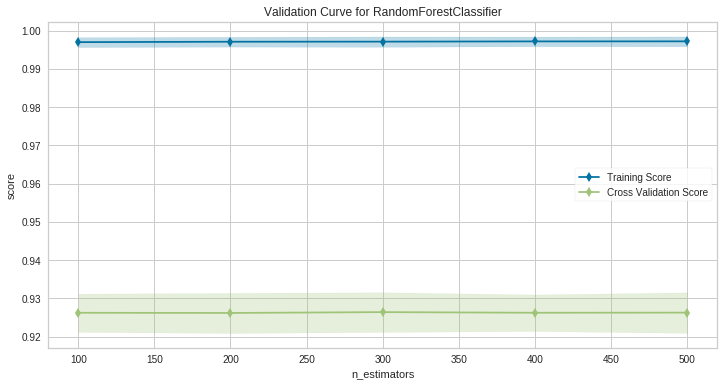

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [100,200,300,400,500]
depth = (range(1,20,4))
param_grid={"n_estimators":base_learners,"max_depth":depth}
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(max_features='sqrt', class_weight="balanced")
gsv = GridSearchCV(rf, param_grid,scoring='f1',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(X_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best Score: %.2f%%"%(gsv.best_score_*100))
print("Best HyperParameter: ",gsv.best_params_)
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(X_train, y_train)
viz.poof()

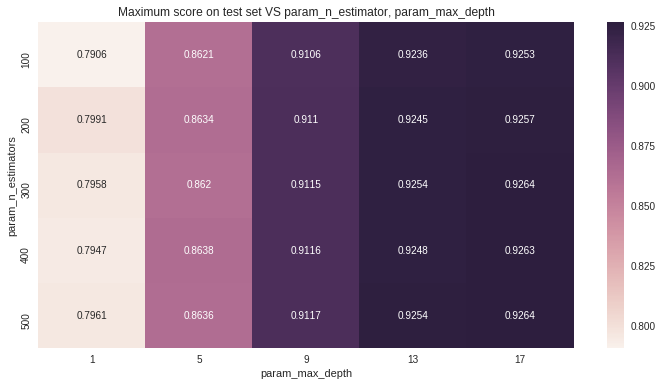

In [48]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

The optimal value of n_estimators is :  300
The optimal value of max_depth is :  17
Accuracy on test set: 86.858%
Precision on test set: 0.887
Recall on test set: 0.965
F1-Score on test set: 0.924


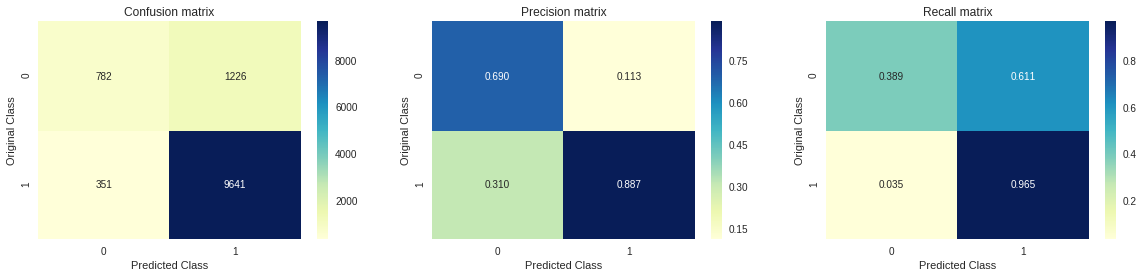

In [49]:
#Testing Accuracy on Test data
print("The optimal value of n_estimators is : ",optimal_n_estimators)
print("The optimal value of max_depth is : ",optimal_max_depth)
rf = RandomForestClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, max_features='sqrt', class_weight="balanced")
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [7.2] GBDT

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 68.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 142.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 209.0min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed: 240.7min finished


Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Best HyperParameter:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 600}
Best Accuracy: 93.28%


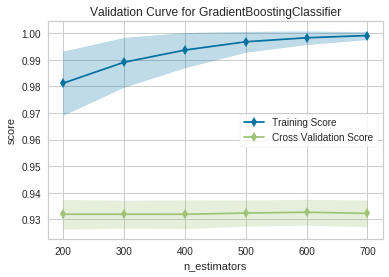

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [200,300,400,500,600,700]
Depths = [1,3,5,7,9,11,15]
Learning_rate = [0.05,0.1,0.2,0.3,0.5]

param_grid = {'n_estimators': base_learners, 'max_depth':Depths, 'learning_rate':Learning_rate}
tscv = TimeSeriesSplit(n_splits=5)
gb = GradientBoostingClassifier(max_features='sqrt')
gsv = GridSearchCV(gb, param_grid,scoring='f1',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(X_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth
optimal_learning_rate = gsv.best_estimator_.learning_rate

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(X_train, y_train)
viz.poof()

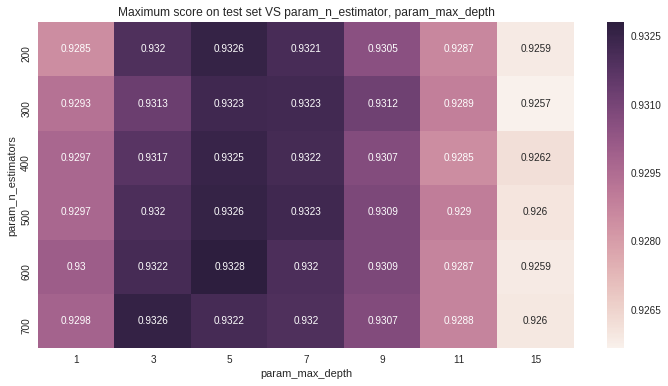

In [35]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

The optimal value of n_estimators is :  600
The optimal value of max_depth is :  5
The optimal value of learning_rate is :  0.1
Accuracy on test set: 87.667%
Precision on test set: 0.894
Recall on test set: 0.964
F1-Score on test set: 0.927


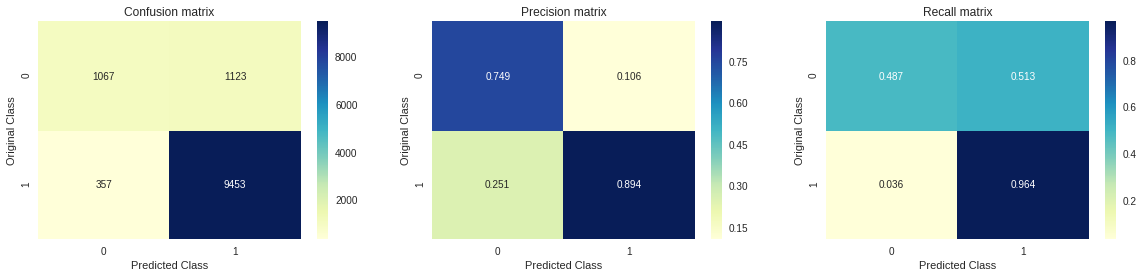

In [38]:
#Testing Accuracy on Test data
print("The optimal value of n_estimators is : ",optimal_n_estimators)
print("The optimal value of max_depth is : ",optimal_max_depth)
print("The optimal value of learning_rate is : ",optimal_learning_rate)

gb = GradientBoostingClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, learning_rate=optimal_learning_rate, max_features='sqrt')
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

# [8] TF-IDF Word2Vec

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(data['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [26]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 40000/40000 [01:02<00:00, 639.13it/s]


In [0]:
# Spliting into Train and test
X_train, X_test, y_train, y_test = train_test_split(tfidf_sent_vectors, data['Score'].values, test_size=0.3, shuffle=False)

## [ 8.1] Random Forest

### [8.1.1] Grid Search

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 28.3min finished


Model with best parameters :
 RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=17, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Best Score: 92.43%
Best HyperParameter:  {'max_depth': 17, 'n_estimators': 400}


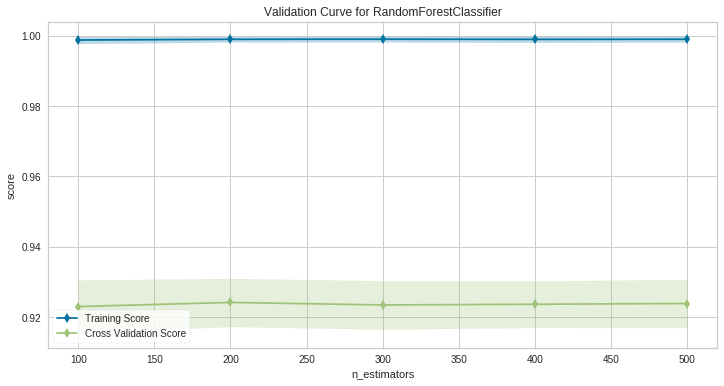

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [100,200,300,400,500]
depth = (range(1,20,4))
param_grid={"n_estimators":base_learners,"max_depth":depth}
tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(max_features='sqrt', class_weight="balanced")
gsv = GridSearchCV(rf, param_grid,scoring='f1',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(X_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best Score: %.2f%%"%(gsv.best_score_*100))
print("Best HyperParameter: ",gsv.best_params_)
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(X_train, y_train)
viz.poof()

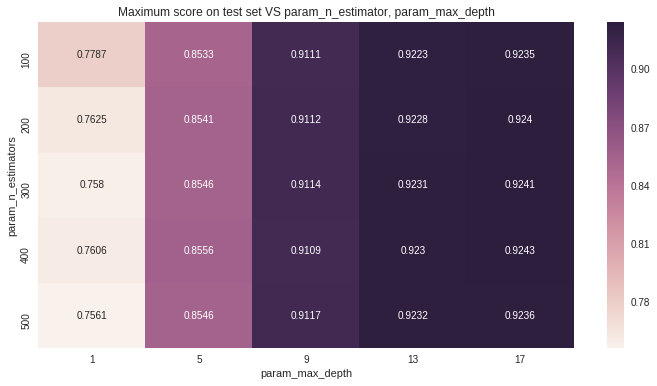

In [43]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

The optimal value of n_estimators is :  400
The optimal value of max_depth is :  17
Accuracy on test set: 84.992%
Precision on test set: 0.859
Recall on test set: 0.977
F1-Score on test set: 0.914


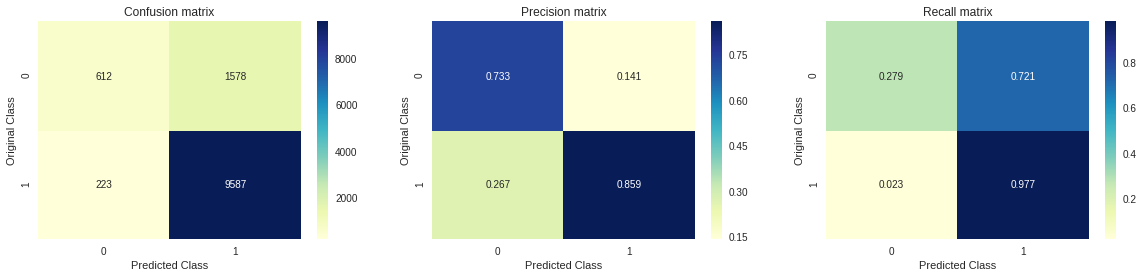

In [44]:
#Testing Accuracy on Test data
print("The optimal value of n_estimators is : ",optimal_n_estimators)
print("The optimal value of max_depth is : ",optimal_max_depth)
rf = RandomForestClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, max_features='sqrt', class_weight="balanced")
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

## [8.2] GBDT

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 69.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 142.5min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 204.2min
[Parallel(n_jobs=-1)]: Done 1050 out of 1050 | elapsed: 236.4min finished


Model with best parameters :
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=5,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=600,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)
Best HyperParameter:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 600}
Best Accuracy: 93.06%


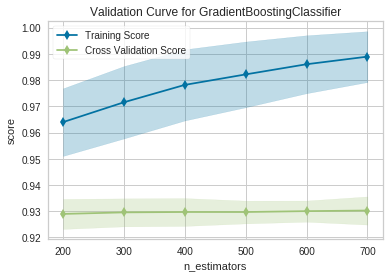

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import ValidationCurve

base_learners = [200,300,400,500,600,700]
Depths = [1,3,5,7,9,11,15]
Learning_rate = [0.05,0.1,0.2,0.3,0.5]

param_grid = {'n_estimators': base_learners, 'max_depth':Depths, 'learning_rate':Learning_rate}
tscv = TimeSeriesSplit(n_splits=5)
gb = GradientBoostingClassifier(max_features='sqrt')
gsv = GridSearchCV(gb, param_grid,scoring='f1',cv=tscv,n_jobs=-1,verbose=1)
gsv.fit(X_train, y_train)
cv_scores = gsv.cv_results_['mean_test_score']
print("Model with best parameters :\n",gsv.best_estimator_)
print("Best HyperParameter: ",gsv.best_params_)
print("Best Accuracy: %.2f%%"%(gsv.best_score_*100))
optimal_n_estimators = gsv.best_estimator_.n_estimators
optimal_max_depth = gsv.best_estimator_.max_depth
optimal_learning_rate = gsv.best_estimator_.learning_rate

#Validation Curve
viz = ValidationCurve(gsv.best_estimator_, param_name="n_estimators",param_range=base_learners, cv=tscv, scoring='f1')
viz.fit(X_train, y_train)
viz.poof()

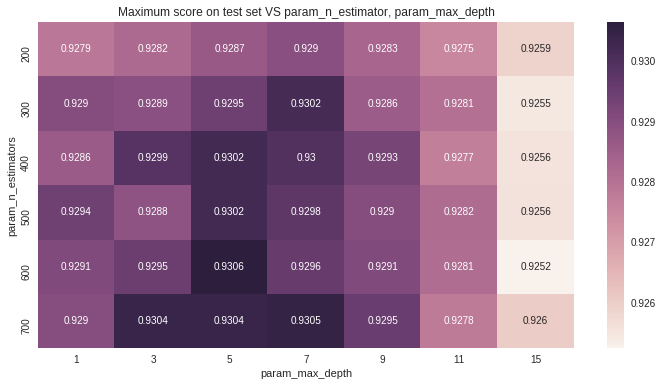

In [29]:
df_gridsearch = pd.DataFrame(gsv.cv_results_)
max_scores = df_gridsearch.groupby(['param_n_estimators','param_max_depth']).max().unstack()[['mean_test_score', 'mean_train_score']]
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 6)
title = 'Maximum score on test set VS param_n_estimator, param_max_depth'
fmt = 'png'
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');
plt.title(title);

The optimal value of n_estimators is :  600
The optimal value of max_depth is :  5
The optimal value of learning_rate is :  0.05
Accuracy on test set: 87.258%
Precision on test set: 0.888
Recall on test set: 0.968
F1-Score on test set: 0.927


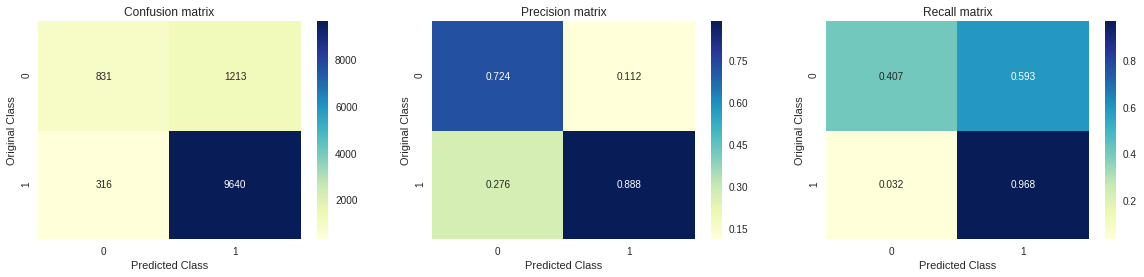

In [32]:
#Testing Accuracy on Test data
print("The optimal value of n_estimators is : ",optimal_n_estimators)
print("The optimal value of max_depth is : ",optimal_max_depth)
print("The optimal value of learning_rate is : ",optimal_learning_rate)

gb = GradientBoostingClassifier(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth, learning_rate=optimal_learning_rate, max_features='sqrt')
gb.fit(X_train,y_train)
y_pred = gb.predict(X_test)
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("Precision on test set: %0.3f"%(precision_score(y_test, y_pred)))
print("Recall on test set: %0.3f"%(recall_score(y_test, y_pred)))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred)))
plot_confusion_matrix(y_test, y_pred)

In [4]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["FEATURIZATION", "MAX-DEPTH", "BASE-LEARNERS", "F1-SCORE"]
 
x.add_row(["BOW", 17, 200, 0.893]) 
x.add_row(["TF_IDF", 17, 300, 0.887]) 
x.add_row(["AVG_W2VEC", 17, 300, 0.924]) 
x.add_row(["TFIDF_W2VEC", 17, 400, 0.914]) 
 
print('\t\t\tRANDOM FOREST')
print(x)

			RANDOM FOREST
+---------------+-----------+---------------+----------+
| FEATURIZATION | MAX-DEPTH | BASE-LEARNERS | F1-SCORE |
+---------------+-----------+---------------+----------+
|      BOW      |     17    |      200      |  0.893   |
|     TF_IDF    |     17    |      300      |  0.887   |
|   AVG_W2VEC   |     17    |      300      |  0.924   |
|  TFIDF_W2VEC  |     17    |      400      |  0.914   |
+---------------+-----------+---------------+----------+


In [5]:
from prettytable import PrettyTable    
x = PrettyTable()
 
x.field_names = ["FEATURIZATION", "MAX-DEPTH", "BASE-LEARNERS", "LEARNING-RATE", "F1-SCORE"]
 
x.add_row(["BOW", 5, 700, 0.1, 0.934]) 
x.add_row(["TF_IDF", 7, 600, 0.1, 0.933]) 
x.add_row(["AVG_W2VEC", 5, 600, 0.1, 0.927]) 
x.add_row(["TFIDF_W2VEC", 5, 600, 0.05, 0.927]) 

print('\t\t\tGBDT')
print(x)

			GBDT
+---------------+-----------+---------------+---------------+----------+
| FEATURIZATION | MAX-DEPTH | BASE-LEARNERS | LEARNING-RATE | F1-SCORE |
+---------------+-----------+---------------+---------------+----------+
|      BOW      |     5     |      700      |      0.1      |  0.934   |
|     TF_IDF    |     7     |      600      |      0.1      |  0.933   |
|   AVG_W2VEC   |     5     |      600      |      0.1      |  0.927   |
|  TFIDF_W2VEC  |     5     |      600      |      0.05     |  0.927   |
+---------------+-----------+---------------+---------------+----------+


# Conclusion

  1. AVG_W2VEC Featurization in Random Forest (BASE-LEARNERS=300) with random search gave the best results with F1-score of 0.924.
  2. BOW Featurization in GBDT (BASE-LEARNERS=700, DEPTH=5, LEARNING-RATE=0.1) gave the best results with F1-score of 0.934.
